In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

import tensorflow as tf

from libs import utils

In [2]:
import csv
from urllib.request import urlretrieve
from urllib.error import HTTPError
from ssl import CertificateError

In [3]:
urls = [l[2] for l in csv.reader(open('Bing Search API-Image.csv')) if l[2].endswith('.jpg')]

In [4]:
dirname = 'jolies/'
count = 0
while count < 100:
    try:
        file_name = '%04d.jpg' % count
        urlretrieve(urls[np.random.randint(len(urls))], dirname + file_name)
        count += 1
    except (HTTPError, CertificateError):
        pass

In [5]:
filenames = [dirname + fname for fname in os.listdir(dirname) if fname.endswith('.jpg')]
assert len(filenames) == 100

In [6]:
file_name = '0005.jpg'
urlretrieve(urls[np.random.randint(len(urls))], dirname + file_name)

('jolies/0005.jpg', <http.client.HTTPMessage at 0x116af9160>)

In [7]:
imgs = [plt.imread(fname)[:, :, :3] for fname in filenames]

In [8]:
for fname in filenames:
    try:
        plt.imread(fname)[:, :, :3]
    except IndexError:
        print(fname)

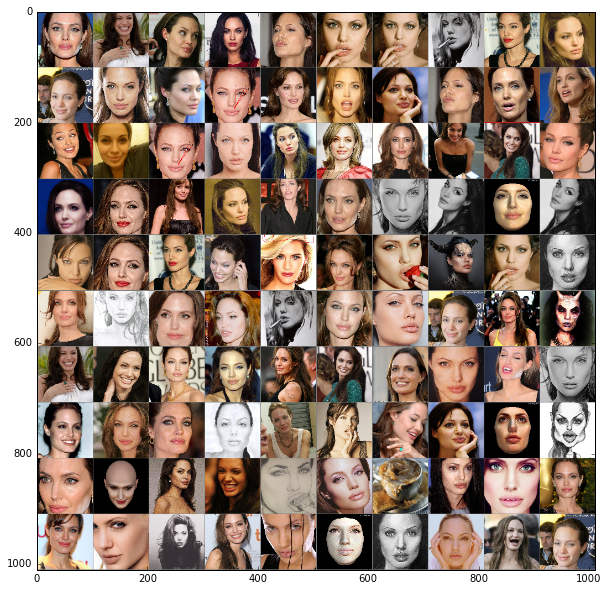

In [9]:
imgs = [utils.imcrop_tosquare(img_i) for img_i in imgs]

imgs = [resize(img_i, (100, 100)) for img_i in imgs]

imgs = np.array(imgs).astype(np.float32)

assert imgs.shape == (100, 100, 100, 3)

plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(imgs, saveto='dataset.png'))

In [10]:
sess = tf.Session(graph=tf.get_default_graph())
mean_img_op = tf.reduce_mean(imgs, 0)

In [11]:
mean_img = sess.run(mean_img_op)

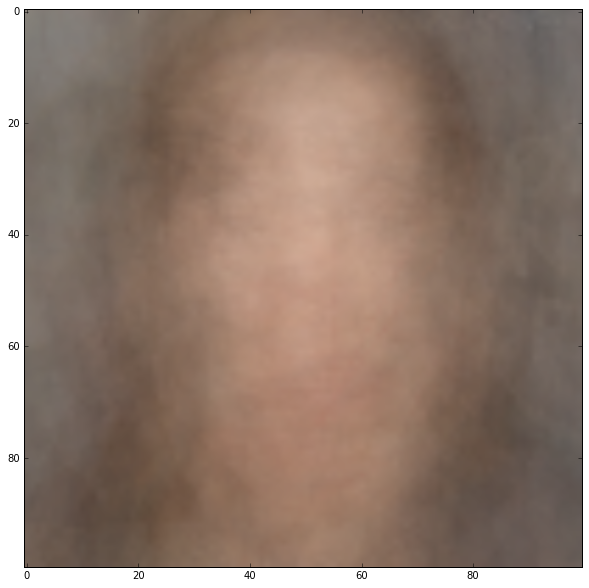

In [12]:
assert mean_img.shape == (100, 100, 3)
plt.figure(figsize=(10, 10))
plt.imshow(mean_img)
plt.imsave(arr=mean_img, fname='mean.png')

In [13]:
subtraction = imgs - mean_img_op

In [14]:
std_img_op = tf.sqrt(tf.reduce_sum(subtraction * subtraction, 0))
std_img = sess.run(std_img_op)

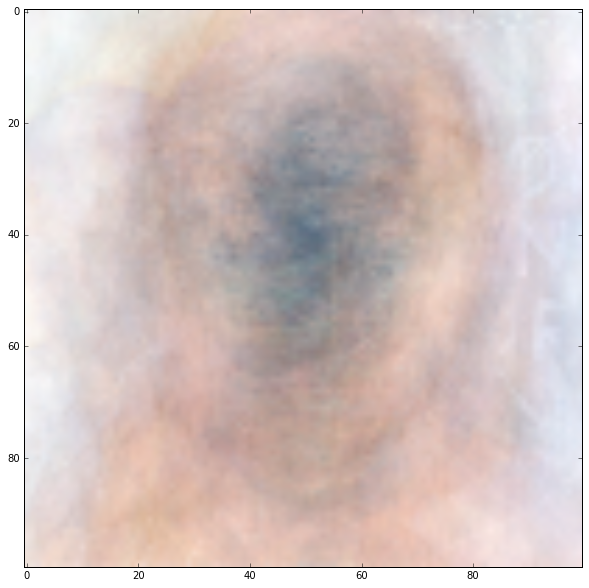

In [15]:
assert std_img.shape == (100, 100, 3)
plt.figure(figsize=(10, 10))
std_img_show = std_img / np.max(std_img)
plt.imshow(std_img_show)
plt.imsave(arr=std_img_show, fname='std.png')

In [16]:
norm_imgs_op = tf.div((imgs - mean_img), std_img)
norm_imgs = sess.run(norm_imgs_op)
np.min(norm_imgs), np.max(norm_imgs), imgs.dtype

(-0.43661952, 0.34043252, dtype('float32'))

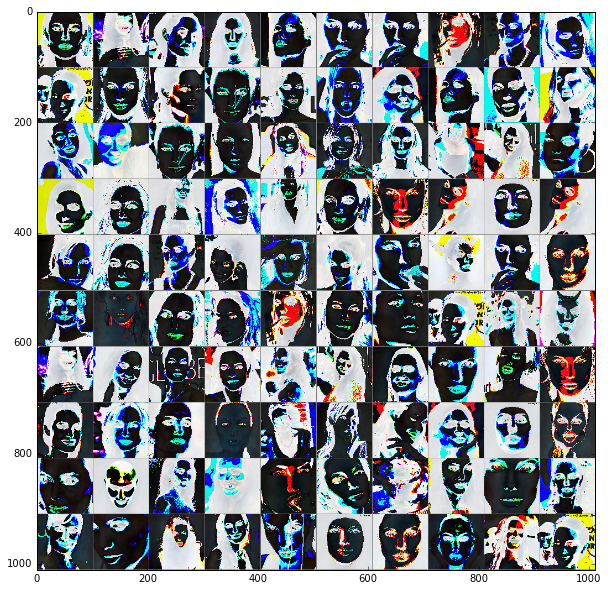

In [17]:
assert norm_imgs.shape == (100, 100, 100, 3)
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(norm_imgs, 'normalized.png'))

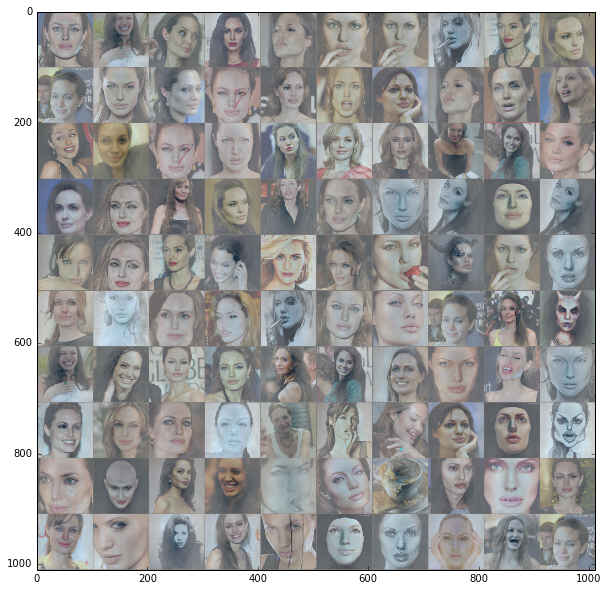

In [18]:
norm_imgs_show = (norm_imgs - np.min(norm_imgs)) / (np.max(norm_imgs) - np.min(norm_imgs))
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(norm_imgs_show, 'normalized.png'))

In [20]:
ksize = 100
kernel = np.concatenate([utils.gabor(ksize)[:, :, np.newaxis] 
                         for i in range(3)], axis=2)
kernel_4d = tf.expand_dims(kernel, 3).eval(session=sess)
assert kernel_4d.shape == (ksize, ksize, 3, 1)

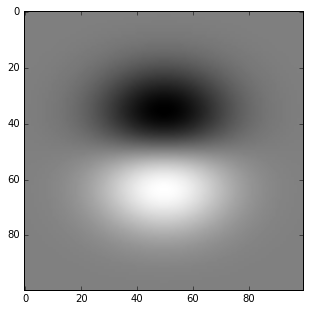

In [21]:
plt.figure(figsize=(5, 5))
plt.imshow(kernel_4d[:, :, 0, 0], cmap='gray')
plt.imsave(arr=kernel_4d[:, :, 0, 0], fname='kernel.png', cmap='gray')

In [22]:
imgs.shape

(100, 100, 100, 3)

In [23]:
convolved = utils.convolve(imgs, kernel_4d)

In [24]:
convolved_show = (convolved - np.min(convolved)) / (np.max(convolved) - np.min(convolved))
convolved_show.shape

(100, 100, 100, 1)

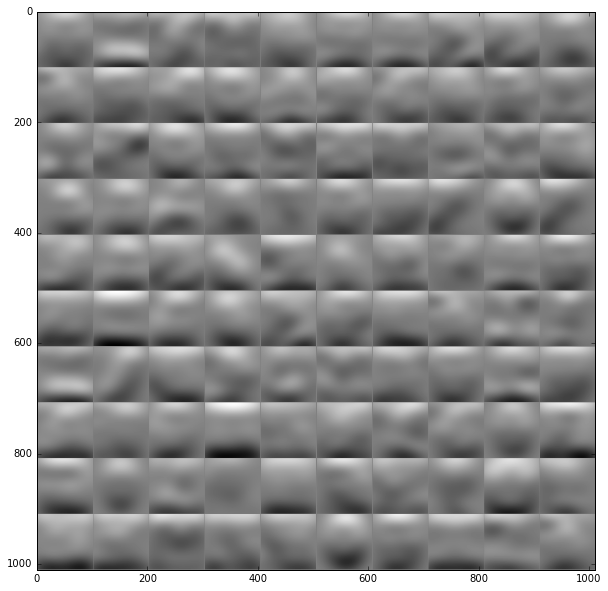

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(convolved_show[:, :, :, 0], 'convolved.png'), cmap='gray')

In [26]:
flattened = tf.reshape(convolved, (100, 10000))
assert flattened.get_shape().as_list() == [100, 10000]

In [27]:
values = tf.reduce_sum(flattened, 1)

idxs_op = tf.nn.top_k(values, k=100)[1]
idxs = sess.run(idxs_op)

sorted_imgs = np.array([imgs[idx_i] for idx_i in idxs])

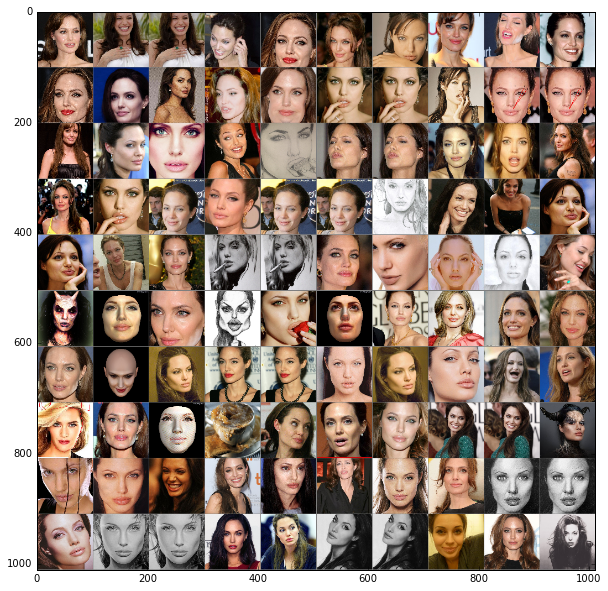

In [28]:
assert sorted_imgs.shape == (100, 100, 100, 3)
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(sorted_imgs, 'sorted.png'))

In [29]:
utils.build_submission('session-1.zip', 
                       ('dataset.png', 
                        'mean.png',
                        'std.png',
                        'normalized.png',
                        'kernel.png',
                        'convolved.png',
                        'sorted.png',
                        'session-1.ipynb'))

It looks like you have completed each part!
Great job!!!
Now submit the file:
/Users/km/Dropbox/notebooks/kadenze/CADL/session-1/session-1.zip
to Kadenze for grading!
